In [1]:
import pandas as pd

# Load the provided datasets
train_df = pd.read_csv(r'C:\Users\OJH\OneDrive\SKKU\연구자료\Catalyst AI_rev\New Database\Na_W_Mn_Cat_train_rev.csv')
test_df = pd.read_csv(r'C:\Users\OJH\OneDrive\SKKU\연구자료\Catalyst AI_rev\New Database\Na_W_Mn_Cat_test_rev.csv')

# Display the first few rows of each dataset for an overview
train_df.head(), test_df.head()

(   Temperature  pCH4_per_pO2  Contact time  Y(C2)_predicted
 0       1083.0           4.9          0.04        12.047283
 1       1023.0           4.0          0.06         7.919782
 2       1073.0           4.0          0.55        14.661379
 3       1073.0           5.0          0.55        13.831947
 4       1023.0           4.0          0.37         7.904139,
    Temperature  pCH4_per_pO2  Contact time  Y(C2)_predicted
 0       1092.0           2.1          0.15        16.146929
 1       1124.0           2.2          0.15        17.852878
 2       1175.0           2.0          0.15        23.288527
 3       1123.0           2.7          0.15        17.690870
 4       1151.0           2.7          0.15        20.950115)

In [2]:
train_df.describe()

,Temperature,pCH4_per_pO2,Contact time,Y(C2)_predicted
count,462.000000,462.000000,462.000000,462.000000
mean,1025.512121,4.965152,0.279519,6.450782
std,46.573333,0.660636,0.150204,5.333248
min,948.000000,4.000000,0.010000,0.000000
25%,978.200000,4.500000,0.144000,0.743255
50%,1024.600000,5.000000,0.288000,6.022480
75%,1071.000000,5.500000,0.432000,11.650596
max,1113.000000,6.000000,0.550000,20.553239


In [3]:
# Extracting the independent variables (X) and the dependent variable (y)
X_train = train_df[['Temperature', 'pCH4_per_pO2', 'Contact time']]
y_train = train_df['Y(C2)_predicted']
X_test = test_df[['Temperature', 'pCH4_per_pO2', 'Contact time']]
y_test = test_df['Y(C2)_predicted']

# Determining the range of each variable in the training data
train_range = {
    'Temperature': (X_train['Temperature'].min(), X_train['Temperature'].max()),
    'pCH4_per_pO2': (X_train['pCH4_per_pO2'].min(), X_train['pCH4_per_pO2'].max()),
    'Contact time': (X_train['Contact time'].min(), X_train['Contact time'].max())
}
# Function to determine the extrapolation strength for a given observation
def determine_extrapolation_strength(row, train_range):
    strength = 0
    for col in train_range:
        if row[col] < train_range[col][0] or row[col] > train_range[col][1]:
            strength += 1
    return strength

# Applying the function to the test data
test_df['Extrapolation Strength'] = test_df.apply(lambda row: determine_extrapolation_strength(row, train_range), axis=1)

# Displaying the first few rows of the modified test data
test_df.head()

,Temperature,pCH4_per_pO2,Contact time,Y(C2)_predicted,Extrapolation Strength
0,1092.0,2.1,0.15,16.146929,1
1,1124.0,2.2,0.15,17.852878,2
2,1175.0,2.0,0.15,23.288527,2
3,1123.0,2.7,0.15,17.690870,2
4,1151.0,2.7,0.15,20.950115,2


In [4]:
# Function to identify which variables are contributing to the extrapolation strength for each observation
def identify_extrapolating_variables(row, train_range):
    extrapolating_vars = []
    for col in train_range:
        if row[col] < train_range[col][0] or row[col] > train_range[col][1]:
            extrapolating_vars.append(col)
    return extrapolating_vars

# Applying the function to the test data
test_df['Extrapolating Variables'] = test_df.apply(lambda row: identify_extrapolating_variables(row, train_range), axis=1)

# Filtering the test data for extrapolation strengths 1 and 2
extrapolation_1_df = test_df[test_df['Extrapolation Strength'] == 1]
extrapolation_2_df = test_df[test_df['Extrapolation Strength'] == 2]
extrapolation_3_df = test_df[test_df['Extrapolation Strength'] == 3]

# Identifying the unique combinations of extrapolating variables for extrapolation strengths 1 and 2
unique_extrapolating_vars_1 = extrapolation_1_df['Extrapolating Variables'].value_counts()
unique_extrapolating_vars_2 = extrapolation_2_df['Extrapolating Variables'].value_counts()
unique_extrapolating_vars_3 = extrapolation_3_df['Extrapolating Variables'].value_counts()

unique_extrapolating_vars_1, unique_extrapolating_vars_2, unique_extrapolating_vars_3

([Temperature]     894
 [Contact time]    882
 [pCH4_per_pO2]    633
 Name: Extrapolating Variables, dtype: int64,
 [Temperature, Contact time]     1764
 [Temperature, pCH4_per_pO2]     1206
 [pCH4_per_pO2, Contact time]    1185
 Name: Extrapolating Variables, dtype: int64,
 [Temperature, pCH4_per_pO2, Contact time]    2352
 Name: Extrapolating Variables, dtype: int64)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [6]:
from xgboost import XGBRegressor
import optuna
import os
import wandb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
from itertools import product

# 예측 결과를 저장할 리스트 초기화
predictions_list = []

# Define your hyperparameter space
n_estimators_options = [250, 500, 750, 1000]
max_depth_options = [5, 10, 50]
min_child_weight_options = [1, 5, 10]
gamma_options = [2, 4, 6, 8, 10]
subsample_options = [0.5, 0.75, 1]
colsample_bytree = 1
learning_rate_options = [0.0001, 0.001, 0.01, 0.1]

# 모든 하이퍼파라미터 조합에 대해 반복
for n_estimators, max_depth, min_child_weight, subsample, gamma, learning_rate in product(
    n_estimators_options, max_depth_options, min_child_weight_options, subsample_options, gamma_options, learning_rate_options):
    
    # XGBRegressor 모델 구성
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        random_state=42  # 재현성 확보
    )
    
    # 모델 학습 (여기서 X_train_scaled, y_train_scaled를 사용해야 함)
    model.fit(X_train_scaled, y_train_scaled)
    
    # X_test_scaled에 대한 예측 수행
    predictions = model.predict(X_test_scaled)
    
    # 예측 결과 저장
    predictions_list.append(predictions)

# 예측 리스트를 DataFrame으로 변환
predictions_df = pd.DataFrame(predictions_list).T  # 각 행이 하나의 예측 지점, 각 열이 하이퍼파라미터 조합에 대한 예측값

# 각 예측 지점에 대한 평균과 표준편차 계산
predictions_df['mean'] = predictions_df.mean(axis=1)
predictions_df['std'] = predictions_df.std(axis=1)

# 결과 출력
print(predictions_df[['mean', 'std']])

          mean       std
0     0.746390  0.435905
1     0.814262  0.489558
2     0.814262  0.489558
3     0.814262  0.489558
4     0.814262  0.489558
...        ...       ...
8911  0.844047  0.515652
8912  0.844047  0.515652
8913  0.844047  0.515652
8914  0.844047  0.515652
8915  0.844047  0.515652

[8916 rows x 2 columns]


In [7]:
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,2152,2153,2154,2155,2156,2157,2158,2159,mean,std
0,0.037973,0.334189,1.067952,1.096883,0.038002,0.335495,1.020228,0.968267,0.038002,0.336028,...,0.149312,0.965326,1.132224,1.178118,0.149312,0.935640,1.116146,1.121406,0.746390,0.435905
1,0.037973,0.341230,1.264247,1.324448,0.038002,0.341719,1.225279,1.277850,0.038002,0.341721,...,0.149312,0.965326,1.176425,1.215889,0.149312,0.935640,1.142312,1.166026,0.814262,0.489558
2,0.037973,0.341230,1.264247,1.324448,0.038002,0.341719,1.225279,1.277850,0.038002,0.341721,...,0.149312,0.965326,1.176425,1.215889,0.149312,0.935640,1.142312,1.166026,0.814262,0.489558
3,0.037973,0.341230,1.264247,1.324448,0.038002,0.341719,1.225279,1.277850,0.038002,0.341721,...,0.149312,0.965326,1.176425,1.215889,0.149312,0.935640,1.142312,1.166026,0.814262,0.489558
4,0.037973,0.341230,1.264247,1.324448,0.038002,0.341719,1.225279,1.277850,0.038002,0.341721,...,0.149312,0.965326,1.176425,1.215889,0.149312,0.935640,1.142312,1.166026,0.814262,0.489558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911,0.037973,0.341230,1.323623,1.391956,0.038002,0.341719,1.285820,1.343803,0.038002,0.341721,...,0.149312,0.976540,1.246637,1.274624,0.149312,0.957987,1.212527,1.250931,0.844047,0.515652
8912,0.037973,0.341230,1.323623,1.391956,0.038002,0.341719,1.285820,1.343803,0.038002,0.341721,...,0.149312,0.976540,1.246637,1.274624,0.149312,0.957987,1.212527,1.250931,0.844047,0.515652
8913,0.037973,0.341230,1.323623,1.391956,0.038002,0.341719,1.285820,1.343803,0.038002,0.341721,...,0.149312,0.976540,1.246637,1.274624,0.149312,0.957987,1.212527,1.250931,0.844047,0.515652
8914,0.037973,0.341230,1.323623,1.391956,0.038002,0.341719,1.285820,1.343803,0.038002,0.341721,...,0.149312,0.976540,1.246637,1.274624,0.149312,0.957987,1.212527,1.250931,0.844047,0.515652


In [8]:
predictions_df['mean']

0       0.746390
1       0.814262
2       0.814262
3       0.814262
4       0.814262
          ...   
8911    0.844047
8912    0.844047
8913    0.844047
8914    0.844047
8915    0.844047
Name: mean, Length: 8916, dtype: float32

In [9]:
Mean = predictions_df['mean']
Mean_original = scaler_y.inverse_transform(Mean.values.reshape(-1, 1))
Mean_original = pd.DataFrame(Mean_original)

In [10]:
Standard_deviation = predictions_df['std']
Standard_deviation_original = scaler_y.inverse_transform(Standard_deviation.values.reshape(-1, 1))
Standard_deviation_original = pd.DataFrame(Standard_deviation_original)

In [11]:
predictions_MC = pd.concat([y_test, Mean_original, Standard_deviation_original], axis=1)
predictions_MC.columns = ['Y(C2)_predicted', 'Mean_MC', 'std_MC']
predictions_MC

,Y(C2)_predicted,Mean_MC,std_MC
0,16.146929,10.427155,8.773054
1,17.852878,10.788738,9.058887
2,23.288527,10.788738,9.058887
3,17.690870,10.788738,9.058887
4,20.950115,10.788738,9.058887
...,...,...,...
8911,20.409223,10.947419,9.197903
8912,20.409223,10.947419,9.197903
8913,20.409223,10.947419,9.197903
8914,20.409223,10.947419,9.197903


In [12]:
predictions_MC = pd.concat([X_test[['Temperature', 'pCH4_per_pO2', 'Contact time']], predictions_MC], axis=1)
predictions_MC

,Temperature,pCH4_per_pO2,Contact time,Y(C2)_predicted,Mean_MC,std_MC
0,1092.0,2.1,0.150,16.146929,10.427155,8.773054
1,1124.0,2.2,0.150,17.852878,10.788738,9.058887
2,1175.0,2.0,0.150,23.288527,10.788738,9.058887
3,1123.0,2.7,0.150,17.690870,10.788738,9.058887
4,1151.0,2.7,0.150,20.950115,10.788738,9.058887
...,...,...,...,...,...,...
8911,1187.0,6.0,1.152,20.409223,10.947419,9.197903
8912,1187.0,6.0,1.224,20.409223,10.947419,9.197903
8913,1187.0,6.0,1.296,20.409223,10.947419,9.197903
8914,1187.0,6.0,1.368,20.409223,10.947419,9.197903


In [13]:
predictions_MC['abs_error_MC'] = abs(predictions_MC['Y(C2)_predicted'] - predictions_MC['Mean_MC'])

In [14]:
predictions_MC.to_csv(r'C:\Users\OJH\OneDrive\SKKU\연구자료\Catalyst AI_rev\New Database\Prediction_uncertainty_MC.csv', index=False)

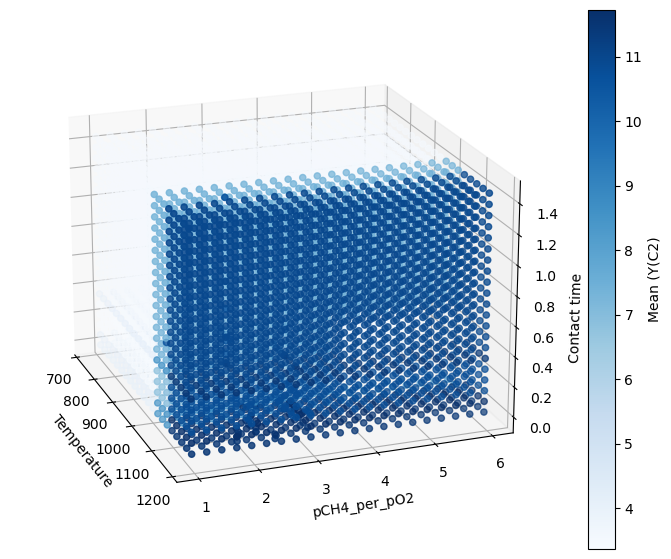

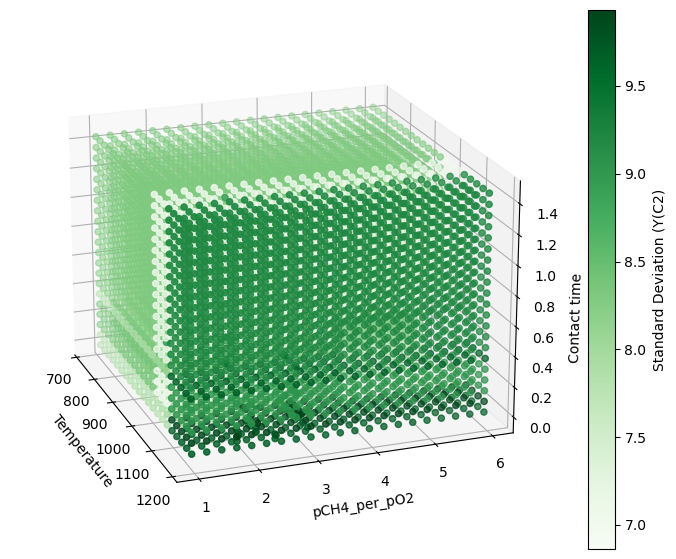

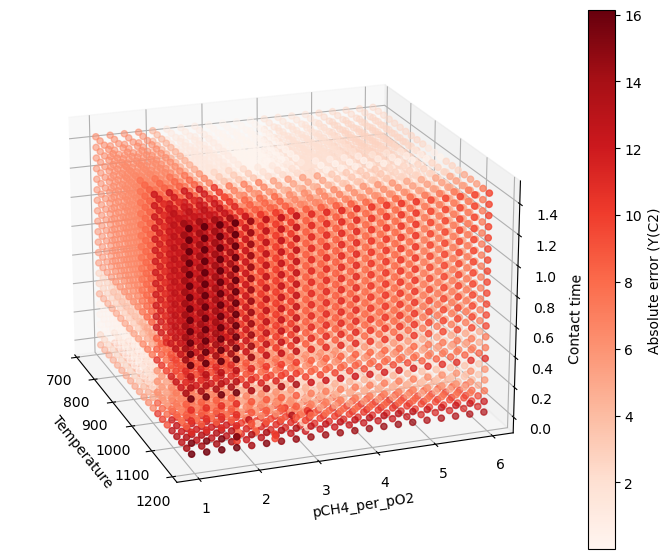

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D plot 생성
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 운전 조건에 따른 평균과 표준편차 플롯
sc = ax.scatter(predictions_MC['Temperature'], predictions_MC['pCH4_per_pO2'], predictions_MC['Contact time'], c=predictions_MC['Mean_MC'], s=20, cmap='Blues')
ax.set_xlabel('Temperature')
ax.set_ylabel('pCH4_per_pO2')
ax.set_zlabel('Contact time')

# 컬러바 추가
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Mean (Y(C2)')


# 표준편차에 대한 3D plot
fig_std = plt.figure(figsize=(10, 7))
ax_std = fig_std.add_subplot(111, projection='3d')

# 운전 조건에 따른 표준편차 플롯
sc_std = ax_std.scatter(predictions_MC['Temperature'], predictions_MC['pCH4_per_pO2'], predictions_MC['Contact time'], c=predictions_MC['std_MC'], s=20, cmap='Greens')
ax_std.set_xlabel('Temperature')
ax_std.set_ylabel('pCH4_per_pO2')
ax_std.set_zlabel('Contact time')

# 컬러바 추가
cbar_std = fig_std.colorbar(sc_std, ax=ax_std)
cbar_std.set_label('Standard Deviation (Y(C2)')


fig_abs = plt.figure(figsize=(10, 7))
ax_abs = fig_abs.add_subplot(111, projection='3d')

# 운전 조건에 따른 표준편차 플롯
sc_abs = ax_abs.scatter(predictions_MC['Temperature'], predictions_MC['pCH4_per_pO2'], predictions_MC['Contact time'], c=predictions_MC['abs_error_MC'], s=20, cmap='Reds')
ax_abs.set_xlabel('Temperature')
ax_abs.set_ylabel('pCH4_per_pO2')
ax_abs.set_zlabel('Contact time')

# 컬러바 추가
cbar_abs = fig_std.colorbar(sc_abs, ax=ax_abs)
cbar_abs.set_label('Absolute error (Y(C2)')

ax.view_init(elev=20, azim=-20)
ax_std.view_init(elev=20, azim=-20)
ax_abs.view_init(elev=20, azim=-20)

plt.show()

New analysis (Extrapolation Zone separation) - Clustering

In [16]:
data = pd.read_csv(r'C:\Users\OJH\OneDrive\SKKU\연구자료\Catalyst AI_rev\New Database\Prediction_uncertainty_MC.csv')

In [17]:
data

,Temperature,pCH4_per_pO2,Contact time,Y(C2)_predicted,Mean_MC,std_MC,abs_error_MC
0,1092.0,2.1,0.150,16.146929,10.427155,8.773054,5.719773
1,1124.0,2.2,0.150,17.852878,10.788738,9.058888,7.064139
2,1175.0,2.0,0.150,23.288527,10.788738,9.058888,12.499789
3,1123.0,2.7,0.150,17.690870,10.788738,9.058888,6.902132
4,1151.0,2.7,0.150,20.950115,10.788738,9.058888,10.161377
...,...,...,...,...,...,...,...
8911,1187.0,6.0,1.152,20.409223,10.947419,9.197903,9.461804
8912,1187.0,6.0,1.224,20.409223,10.947419,9.197903,9.461804
8913,1187.0,6.0,1.296,20.409223,10.947419,9.197903,9.461804
8914,1187.0,6.0,1.368,20.409223,10.947419,9.197903,9.461804


In [18]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

features = data[['Temperature', 'pCH4_per_pO2', 'Contact time', 'std_MC', 'abs_error_MC']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-means, GMM, DBSCAN
kmeans_params = range(2, 11)
gmm_params = range(2, 11)
dbscan_eps = [0.5, 1, 1.5, 2, 2.5]

best_score = -1
best_method = None
best_params = None

# K-means
for k in kmeans_params:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    if score > best_score:
        best_score = score
        best_method = 'K-means'
        best_params = k

# GMM
for k in gmm_params:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    if score > best_score:
        best_score = score
        best_method = 'GMM'
        best_params = k

# DBSCAN
for eps in dbscan_eps:
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(features_scaled)
    # 모든 데이터가 하나의 클러스터에 속하거나, 클러스터가 없는 경우를 제외
    if len(set(labels)) > 1:
        score = silhouette_score(features_scaled, labels)
        if score > best_score:
            best_score = score
            best_method = 'DBSCAN'
            best_params = eps

(best_method, best_params, best_score)

('GMM', 2, 0.3498400358349434)

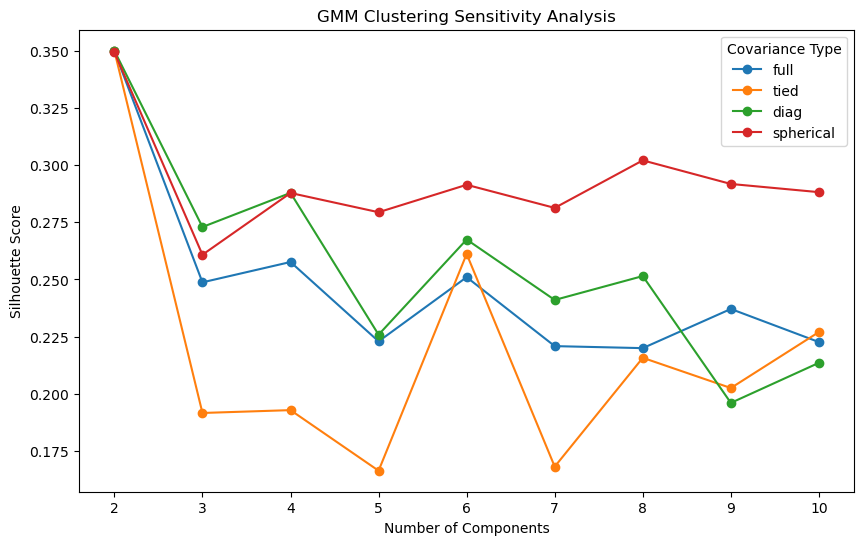

Best configuration: n_components               2
covariance_type         diag
silhouette_score    0.350077
Name: 2, dtype: object


In [19]:
# Define the range of clusters to test
n_components_range = range(2, 11)  # Example: Testing 2 to 10 clusters

# Define the covariance types to test
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Initialize lists to store the results
results = []

for n_components in n_components_range:
    for covariance_type in covariance_types:
        # Initialize and fit the Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        gmm.fit(features_scaled)
        
        # Predict the cluster for each data point
        labels = gmm.predict(features_scaled)
        
        # Calculate the silhouette score for the current configuration
        silhouette_avg = silhouette_score(features_scaled, labels)
        
        # Store the results
        results.append({
            'n_components': n_components,
            'covariance_type': covariance_type,
            'silhouette_score': silhouette_avg
        })

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find the configuration with the highest silhouette score
best_config = results_df.loc[results_df['silhouette_score'].idxmax()]

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for covariance_type in covariance_types:
    subset = results_df[results_df['covariance_type'] == covariance_type]
    ax.plot(subset['n_components'], subset['silhouette_score'], marker='o', label=covariance_type)

ax.set_xlabel('Number of Components')
ax.set_ylabel('Silhouette Score')
ax.set_title('GMM Clustering Sensitivity Analysis')
ax.legend(title='Covariance Type')

plt.show()

print("Best configuration:", best_config)

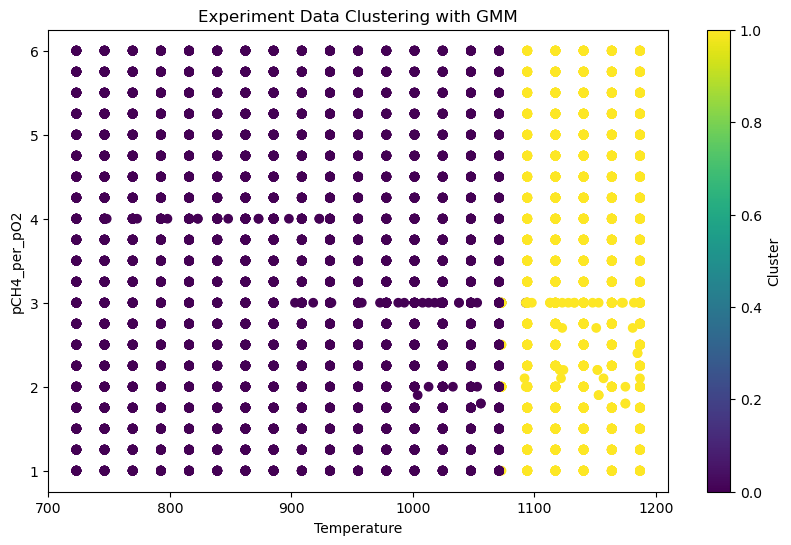

In [20]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', random_state=42)
gmm.fit(features_scaled)

labels = gmm.predict(features_scaled)
data['Cluster'] = labels

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(data['Temperature'], data['pCH4_per_pO2'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('pCH4_per_pO2')
plt.title('Experiment Data Clustering with GMM')
plt.colorbar(label='Cluster')
plt.show()

In [21]:
data_0 = data[data['Cluster'] == 0]
data_1 = data[data['Cluster'] == 1]
data_2 = data[data['Cluster'] == 2]
data_3 = data[data['Cluster'] == 3]
data_4 = data[data['Cluster'] == 4]
data_5 = data[data['Cluster'] == 5]

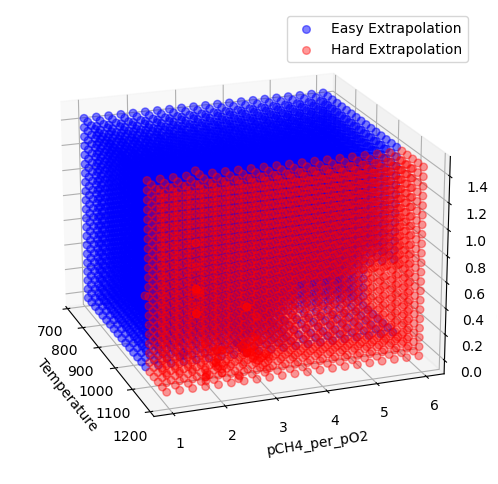

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 11))
ax = fig.add_subplot(111, projection='3d')

# Plotting the interpolation data with lower transparency
ax.scatter(data_0['Temperature'], data_0['pCH4_per_pO2'], data_0['Contact time'], 
           color='blue', label='Easy Extrapolation', s=30, alpha=0.5)

# Plotting the extrapolation data with higher transparency
ax.scatter(data_1['Temperature'], data_1['pCH4_per_pO2'], data_1['Contact time'], 
           color='red', label='Hard Extrapolation', s=30, alpha=0.4)

# Adding a legend
ax.legend()

# Setting labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('pCH4_per_pO2')
ax.set_zlabel('Contact time')

# Showing the plot

ax.view_init(elev=20, azim=-20)
plt.show()

In [24]:
import plotly.graph_objects as go

# Assuming 'scaled_experiment_data_0' and 'scaled_experiment_data_1' are your datasets
# Replace these variable names with your actual DataFrame names
# Ensure these DataFrames have 'Temperature', 'pCH4_per_pO2', and 'Contact time' columns

fig = go.Figure()

# Adding the experiment data 1 scatter plot
fig.add_trace(go.Scatter3d(
    x=data_0['Temperature'],
    y=data_0['pCH4_per_pO2'],
    z=data_0['Contact time'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,  # lower opacity
        color='blue'
    ),
    name='Easy Extrapolation'
))

# Adding the experiment data 2 scatter plot
fig.add_trace(go.Scatter3d(
    x=data_1['Temperature'],
    y=data_1['pCH4_per_pO2'],
    z=data_1['Contact time'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.3,  # higher opacity
        color='red'
    ),
    name='Hard Extrapolation'
))

fig.add_trace(go.Scatter3d(
    x=data_2['Temperature'],
    y=data_2['pCH4_per_pO2'],
    z=data_2['Contact time'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.3,  # higher opacity
        color='green'
    ),
    name='Cluster 3'
))

fig.add_trace(go.Scatter3d(
    x=data_3['Temperature'],
    y=data_3['pCH4_per_pO2'],
    z=data_3['Contact time'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.3,  # higher opacity
        color='yellow'
    ),
    name='Cluster 4'
))

fig.add_trace(go.Scatter3d(
    x=data_4['Temperature'],
    y=data_4['pCH4_per_pO2'],
    z=data_4['Contact time'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.5,  # higher opacity
        color='purple'
    ),
    name='Cluster 5'
))

fig.add_trace(go.Scatter3d(
    x=data_5['Temperature'],
    y=data_5['pCH4_per_pO2'],
    z=data_5['Contact time'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.3,  # higher opacity
        color='orange'
    ),
    name='Cluster 6'
))

# Setting the layout for the 3D plot
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Temperature',
        yaxis_title='pCH4_per_pO2',
        zaxis_title='Contact time'
    ),
    title='3D Scatter Plot of Variables'
)

fig.show()

In [25]:
data_0 = data_0.drop(['Cluster'], axis=1)
data_1 = data_1.drop(['Cluster'], axis=1)

data_0.to_csv(r'C:\Users\OJH\OneDrive\SKKU\연구자료\Catalyst AI_rev\New Database\Easy_Extrapolation.csv', index=False)
data_1.to_csv(r'C:\Users\OJH\OneDrive\SKKU\연구자료\Catalyst AI_rev\New Database\Hard_Extrapolation.csv', index=False)